# Figure 1-3

Indicator kinetics

In [1]:
import multiprocessing
from itertools import chain, cycle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sb
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

import metadata
from analysis import SESSIONS, binarize, cleanup_grid, get_cells, savefig
from load import load_preprocessed_data, load_preprocessed_events
from metadata import METADATA

In [2]:
tqdm.pandas()

In [3]:
N_CPUS = multiprocessing.cpu_count()

In [4]:
OUTPUT_DIR = Path('figures/fig_1-3')

## Load data

In [5]:
def loader(session):
    events = load_preprocessed_events(session) 
    dff, data = load_preprocessed_data(session)
    return dff, events, data

loaded_data = Parallel(n_jobs=min(len(SESSIONS), N_CPUS), verbose=5)(
    delayed(loader)(session) for session in SESSIONS
)

[Parallel(n_jobs=44)]: Using backend LokyBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done   2 out of  44 | elapsed:    8.0s remaining:  2.8min
[Parallel(n_jobs=44)]: Done  11 out of  44 | elapsed:   12.6s remaining:   37.9s
[Parallel(n_jobs=44)]: Done  20 out of  44 | elapsed:   18.5s remaining:   22.2s
[Parallel(n_jobs=44)]: Done  29 out of  44 | elapsed:   25.3s remaining:   13.1s
[Parallel(n_jobs=44)]: Done  38 out of  44 | elapsed:   38.9s remaining:    6.1s
[Parallel(n_jobs=44)]: Done  44 out of  44 | elapsed:   58.2s finished


In [6]:
DFF = dict()
EVENTS = dict()
DATA = dict()
for session, (dff, events, data) in zip(SESSIONS, loaded_data):
    DFF[session] = dff
    EVENTS[session] = events
    DATA[session] = data

In [7]:
# Attach label columns to dF/F and event dataframes
for session, data in tqdm(DATA.items()):
    labels = data.loc[
        :, ["stimulus", "trial", "stimulus_is_scrambled_pair", "stimulus_is_block"]
    ]
    DFF[session] = DFF[session].merge(
        labels,
        how="left",
        left_index=True,
        right_index=True,
    )
    EVENTS[session] = EVENTS[session].merge(
        labels,
        how="left",
        left_index=True,
        right_index=True,
    )

  0%|          | 0/44 [00:00<?, ?it/s]

## Compute mean event-locked trace for each cell

In [8]:
# Window size, in samples
START = -50
END = 100

### Helper functions for event-locked traces

In [9]:
def select_events(cell, sd_threshold=1.5):
    std = cell.loc[~(cell == 0)].std()
    return cell.loc[cell >= (std * sd_threshold)]

In [10]:
def peri_event_windows(cell, start=None, end=None):
    start = START if start is None else start
    end = END if end is None else end
    events = cell.loc[cell > 0]
    return pd.DataFrame(
        index=events.index,
        data={"start": events.index + start, "end": events.index + end},
    )

In [11]:
def isolated_event_windows(events, windows):
    counts_within_windows = np.nansum(
        binarize(peri_event_traces(events, windows)), axis=0
    )
    assert counts_within_windows.min() > 0
    idx = (counts_within_windows == 1).nonzero()[0]
    return windows.iloc[idx]

In [12]:
def peri_event_traces(cell, windows):
    return pd.DataFrame(
        index=windows.index,
        data=[
            cell.loc[start:end].values for start, end in zip(windows.start, windows.end)
        ],
    ).transpose()

In [13]:
def mean_event_trace(cell, windows):
    return peri_event_traces(cell, windows).mean(axis="columns")

In [14]:
def to_seconds(samples):
    return samples / metadata.TWOP_SAMPLE_RATE

In [15]:
def mean_event_traces(events, dff):
    dff = dff.reset_index(level=["area", "cre", "session"]).loc[:, get_cells(events)]
    events = events.reset_index(level=["area", "cre", "session"]).loc[
        :, get_cells(events)
    ]
    # Get peri-event windows, restricting to isolated events
    window_sets = [
        isolated_event_windows(events[cell], peri_event_windows(events[cell]))
        for cell in events.columns
    ]
    return pd.concat(
            [
                pd.Series(name=cell, data=mean_event_trace(dff[cell], windows))
                for cell, windows in zip(events.columns, window_sets)
            ],
            axis="columns",
        )

### Compute

In [16]:
arg_list = [(EVENTS[session], DFF[session]) for session in SESSIONS]

In [17]:
mean_traces = dict(
    zip(
        SESSIONS,
        Parallel(n_jobs=min(len(SESSIONS), N_CPUS), verbose=5)(
            delayed(mean_event_traces)(*args) for args in arg_list
        ),
    )
)

[Parallel(n_jobs=44)]: Using backend LokyBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done   2 out of  44 | elapsed:    8.5s remaining:  3.0min
[Parallel(n_jobs=44)]: Done  11 out of  44 | elapsed:   21.0s remaining:  1.0min
[Parallel(n_jobs=44)]: Done  20 out of  44 | elapsed:   28.3s remaining:   33.9s
[Parallel(n_jobs=44)]: Done  29 out of  44 | elapsed:   35.2s remaining:   18.2s
[Parallel(n_jobs=44)]: Done  38 out of  44 | elapsed:   48.9s remaining:    7.7s
[Parallel(n_jobs=44)]: Done  44 out of  44 | elapsed:  2.8min finished


## Fit curve for each trace

In [18]:
def exponential(t, a0, a1, lamd):
    return a0 + a1 * np.exp(-(lamd * t))


def r_squared(y, y_fit):
    # Residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    # Total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # R^2
    return 1 - (ss_res / ss_tot)


def fit(
    trace,
    start=START,
    guess=(0.0, 1.0, 1.0),
    maxfev=1e4,
    plot=False,
):
    n = -start
    t = trace.index[n:] - n
    y = trace.values[n:]
    
    # Convert units
    t = to_seconds(t)
    
    optimal, covariance = curve_fit(exponential, t, y, p0=guess, maxfev=int(maxfev))
    y_fit = exponential(t, *optimal)
    return optimal, r_squared(y, y_fit)

In [19]:
def worker(session, cell, trace, **kwargs):
    optimal, r2 = fit(trace, **kwargs) 
    return pd.Series(
        {
            "a0": optimal[0],
            "a1": optimal[1],
            "lambda": optimal[2],
            "r_squared": r2,
            "session": session,
            "cell": cell,
        }
    )

In [20]:
arg_list = list(
    chain(
        *[
            zip(cycle([session]), traces.items())
            for session, traces in mean_traces.items()
        ]
    )
)

In [21]:
results = Parallel(n_jobs=min(len(arg_list), N_CPUS), verbose=5)(
    delayed(worker)(session, cell, trace) for session, (cell, trace) in tqdm(arg_list)
)

  0%|          | 0/4018 [00:00<?, ?it/s]

/home/wmayner/projects/openscope-differentiation/load.py:370: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = scipy.signal.find_peaks(
/home/wmayner/projects/openscope-differentiation/load.py:370: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = scipy.signal.find_peaks(
/home/wmayner/projects/openscope-differentiation/load.py:370: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = scipy.signal.find_peaks(
/home/wmayner/projects/openscope-differentiation/load.py:370: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = scipy.signal.find_peaks(
/home/wmayner/projects/openscope-differentiation/load.py:370: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = scipy.signal.find_peaks(
[Parallel(n_jobs=160)]: Using backend LokyBackend with 160 concurrent workers.
[Parallel(n_jobs=160)]: Done 130 tasks      | elapsed:  1.5min
[Parallel(n_jobs=160)]: Done 328 tasks

In [22]:
df = (
    pd.DataFrame(results)
    .merge(METADATA, on='session')
)

In [23]:
def half_life(lambd):
    return np.log(2) / lambd

df['tau_1/2'] = half_life(df['lambda'])

### Plot worst fit

In [24]:
def plot_fit(row, figsize=(4, 3)):
    fig = plt.figure(figsize=figsize)
    session, cell = row['session'], row['cell']
    trace = (
        mean_traces[row['session']]
        .loc[-START:, row['cell']]
        .reset_index(drop=True)
        .copy()
    )
    
    t = to_seconds(trace.index)
    y = trace.values
    y_fit = exponential(t, *row[['a0', 'a1', 'lambda']])
    
    plt.plot(t, y, "k.")
    plt.plot(t, y_fit, "r-")
    plt.annotate('r^2 = {:.2}'.format(row['r_squared']), (2.5, 0.8*y.max()))
    return fig

session    718673398
cell          cell_5
Name: 803, dtype: object


PosixPath('figures/fig_1-3/example_fit.svg')

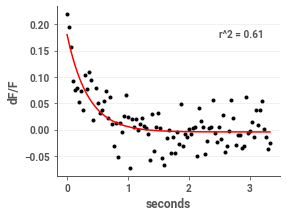

In [25]:
row = df.iloc[df.r_squared.argmin()]
print(row[['session', 'cell']])
fig = plot_fit(row)
plt.ylabel('dF/F')
plt.xlabel('seconds')
savefig(fig, OUTPUT_DIR/'example_fit')

## Analyze by area and layer

### Compute extracted kinetics

In [26]:
time = to_seconds(np.linspace(0, END, num=(END + 1)))

def response_kernel(row):
    return pd.DataFrame({
        't (s)': time,
        'dF/F': exponential(time, *row[['a0', 'a1', 'lambda']]),
        **row[['session', 'layer', 'area', 'cell']],
    })

kinetics = pd.concat(df.progress_apply(response_kernel, axis='columns').values)

  0%|          | 0/4018 [00:00<?, ?it/s]

In [27]:
for col in ['area', 'layer']:
    kinetics[col] = pd.Categorical(kinetics[col], categories=df[col].cat.categories, ordered=True)

In [28]:
kinetics['layer & area'] = kinetics['layer'].astype(str) + ' ' + kinetics['area'].astype(str)

PosixPath('figures/fig_1-3/traces.svg')

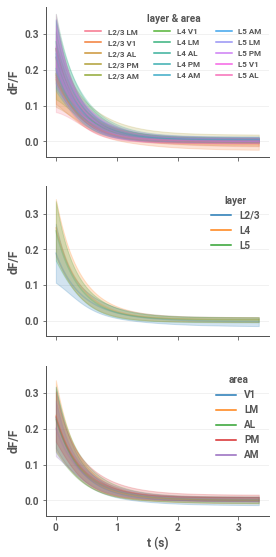

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 9), sharey=True, sharex=True)
for i, hue in enumerate([
    'layer & area',
    'layer',
    'area',
]):
    ax = axes[i]
    sb.lineplot(
        data=kinetics,
        x="t (s)",
        y="dF/F",
        legend=True,
        hue=hue,
        alpha=0.2,
        ci='sd',
        ax=ax,
    )
    if i == 0:
        legend = ax.legend(ncol=3, fontsize=8, title_fontsize=10)
        legend.set_title(hue) 
savefig(fig, OUTPUT_DIR/f'traces')

PosixPath('figures/fig_1-3/r2.svg')

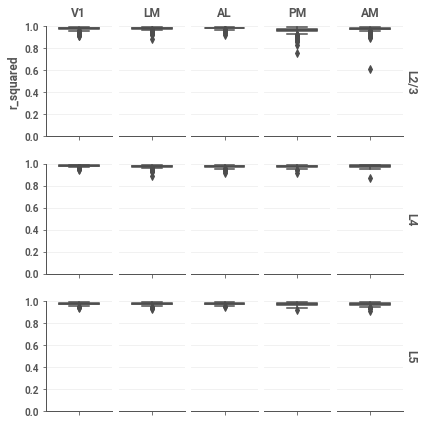

In [30]:
grid = sb.catplot(
    kind="box",
    y="r_squared",
    data=df,
    row="layer",
    col="area",
    width=0.6,
    color="grey",
    height=2.0,
    aspect=0.6,
    margin_titles=True,
)
grid.set(ylim=(0, 1))
grid = cleanup_grid(grid)
plt.subplots_adjust(hspace=0.25)
savefig(grid.fig, OUTPUT_DIR/'r2')

## Stats

In [31]:
%load_ext rpy2.ipython

In [32]:
%%R
library(tidyverse)
library(ggplot2)
library(lme4)
library(broom)
library(multcomp)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: TH.data

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘MASS’


R[write to console]: The following object is masked from ‘package:dp

In [33]:
response = 'tau_1/2'

In [34]:
data = df.loc[:, ['layer', 'area', 'session', response]]

In [35]:
%%R

compare_models = function(data, formula, reduced_formula) {
    # Estimate models
    model = lmer(formula, data=data, REML=FALSE)
    reduced_model = lmer(reduced_formula, data=data, REML=FALSE)

    message('--- Full model ------')
    print(model)
    message('--- Reduced model ---')
    print(reduced_model)
    
    # Compare models
    model_comparison = anova(model, reduced_model)
    model_comparison
}

### Layer * area

In [36]:
formula = f"`{response}` ~ 1 + layer * area + (1 | session)"
reduced_formula = f"`{response}` ~ layer + area + 1 + (1 | session)" 
print(formula)
print(reduced_formula)

`tau_1/2` ~ 1 + layer * area + (1 | session)
`tau_1/2` ~ layer + area + 1 + (1 | session)


In [37]:
%%R -i data -i formula -i reduced_formula 

comparison = compare_models(data, formula, reduced_formula)
print(comparison)

R[write to console]: --- Full model ------



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: `tau_1/2` ~ 1 + layer * area + (1 | session)
   Data: data
      AIC       BIC    logLik  deviance  df.resid 
-13141.24 -13034.17   6587.62 -13175.24      4001 
Random effects:
 Groups   Name        Std.Dev.
 session  (Intercept) 0.06799 
 Residual             0.04572 
Number of obs: 4018, groups:  session, 44
Fixed Effects:
   (Intercept)         layer.L         layer.Q          area.L          area.Q  
      0.295326       -0.017630        0.009714        0.003882        0.006534  
        area.C          area^4  layer.L:area.L  layer.Q:area.L  layer.L:area.Q  
     -0.007684        0.002859        0.007640       -0.003262        0.028089  
layer.Q:area.Q  layer.L:area.C  layer.Q:area.C  layer.L:area^4  layer.Q:area^4  
      0.011126       -0.008761       -0.024714       -0.024483        0.003572  


R[write to console]: --- Reduced model ---



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: `tau_1/2` ~ layer + area + 1 + (1 | session)
   Data: data
       AIC        BIC     logLik   deviance   df.resid 
-13155.947 -13099.260   6586.974 -13173.947       4009 
Random effects:
 Groups   Name        Std.Dev.
 session  (Intercept) 0.06899 
 Residual             0.04572 
Number of obs: 4018, groups:  session, 44
Fixed Effects:
(Intercept)      layer.L      layer.Q       area.L       area.Q       area.C  
   0.295954    -0.016270     0.010497     0.003848     0.004747    -0.007626  
     area^4  
   0.005200  
Data: data
Models:
reduced_model: `tau_1/2` ~ layer + area + 1 + (1 | session)
model: `tau_1/2` ~ 1 + layer * area + (1 | session)
              Df    AIC    BIC logLik deviance Chisq Chi Df Pr(>Chisq)
reduced_model  9 -13156 -13099 6587.0   -13174                        
model         17 -13141 -13034 6587.6   -13175 1.293      8     0.9956


## Layer

In [38]:
formula = f"`{response}` ~ 1 + layer + area + (1 | session)"
reduced_formula = f"`{response}` ~ 1 + area + (1 | session)" 
print(formula)
print(reduced_formula)

`tau_1/2` ~ 1 + layer + area + (1 | session)
`tau_1/2` ~ 1 + area + (1 | session)


In [39]:
%%R -i data -i formula -i reduced_formula 

comparison = compare_models(data, formula, reduced_formula)
print(comparison)

R[write to console]: --- Full model ------



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: `tau_1/2` ~ 1 + layer + area + (1 | session)
   Data: data
       AIC        BIC     logLik   deviance   df.resid 
-13155.947 -13099.260   6586.974 -13173.947       4009 
Random effects:
 Groups   Name        Std.Dev.
 session  (Intercept) 0.06899 
 Residual             0.04572 
Number of obs: 4018, groups:  session, 44
Fixed Effects:
(Intercept)      layer.L      layer.Q       area.L       area.Q       area.C  
   0.295954    -0.016270     0.010497     0.003848     0.004747    -0.007626  
     area^4  
   0.005200  


R[write to console]: --- Reduced model ---



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: `tau_1/2` ~ 1 + area + (1 | session)
   Data: data
       AIC        BIC     logLik   deviance   df.resid 
-13158.804 -13114.714   6586.402 -13172.804       4011 
Random effects:
 Groups   Name        Std.Dev.
 session  (Intercept) 0.06992 
 Residual             0.04572 
Number of obs: 4018, groups:  session, 44
Fixed Effects:
(Intercept)       area.L       area.Q       area.C       area^4  
   0.296160     0.003892     0.004308    -0.007631     0.005830  
Data: data
Models:
reduced_model: `tau_1/2` ~ 1 + area + (1 | session)
model: `tau_1/2` ~ 1 + layer + area + (1 | session)
              Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)
reduced_model  7 -13159 -13115 6586.4   -13173                         
model          9 -13156 -13099 6587.0   -13174 1.1431      2     0.5647


## Area

In [40]:
formula = f"`{response}` ~ 1 + layer + area + (1 | session)"
reduced_formula = f"`{response}` ~ 1 + layer + (1 | session)" 
print(formula)
print(reduced_formula)

`tau_1/2` ~ 1 + layer + area + (1 | session)
`tau_1/2` ~ 1 + layer + (1 | session)


In [41]:
%%R -i data -i formula -i reduced_formula 

comparison = compare_models(data, formula, reduced_formula)
print(comparison)

R[write to console]: --- Full model ------



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: `tau_1/2` ~ 1 + layer + area + (1 | session)
   Data: data
       AIC        BIC     logLik   deviance   df.resid 
-13155.947 -13099.260   6586.974 -13173.947       4009 
Random effects:
 Groups   Name        Std.Dev.
 session  (Intercept) 0.06899 
 Residual             0.04572 
Number of obs: 4018, groups:  session, 44
Fixed Effects:
(Intercept)      layer.L      layer.Q       area.L       area.Q       area.C  
   0.295954    -0.016270     0.010497     0.003848     0.004747    -0.007626  
     area^4  
   0.005200  


R[write to console]: --- Reduced model ---



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: `tau_1/2` ~ 1 + layer + (1 | session)
   Data: data
       AIC        BIC     logLik   deviance   df.resid 
-13163.718 -13132.226   6586.859 -13173.718       4013 
Random effects:
 Groups   Name        Std.Dev.
 session  (Intercept) 0.06917 
 Residual             0.04572 
Number of obs: 4018, groups:  session, 44
Fixed Effects:
(Intercept)      layer.L      layer.Q  
    0.29591     -0.01634      0.01047  
Data: data
Models:
reduced_model: `tau_1/2` ~ 1 + layer + (1 | session)
model: `tau_1/2` ~ 1 + layer + area + (1 | session)
              Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)
reduced_model  5 -13164 -13132 6586.9   -13174                         
model          9 -13156 -13099 6587.0   -13174 0.2288      4     0.9939
